In [206]:
import torch
from torch.utils import data
from torch import nn
import sklearn.datasets
import time
import matplotlib.pyplot as plt
import numpy as np
import wandb
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [207]:
class TwoMoonsClassification:
    def forward(self, X, W1, W2):
        res1 = torch.mm(X, W1)
        res11 = torch.where(res1 < 0, 0, res1)
        res2 = torch.sum(torch.mm(res11, W2))
        return res2

    def sigmoid(self, out):
        return 1 / (1 + torch.exp(-out))

    def loss(self, x, W1, W2, y):
        return -torch.dot(
            y, torch.log(self.sigmoid(self.forward(x, W1, W2)))
        ) - torch.dot(1 - y, torch.log(1 - self.sigmoid(self.forward(x, W1, W2))))

In [208]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [209]:
class ModelTrainerExperiment1:
    def __init__(self, n_train, n_test, w_hidden):
        # generate data
        self.n_train = n_train
        self.n_test = n_test
        self.n = n_train + n_test
        self.X, self.Y = sklearn.datasets.make_moons(
            n_samples=self.n, noise=0.1, random_state=0
        )
        self.X = torch.from_numpy(self.X).float()
        self.Y = torch.from_numpy(self.Y).float().reshape(-1)
        self.X_train, self.Y_train = self.X[:n_train], self.Y[:n_train]
        self.X_test, self.Y_test = self.X[n_train:], self.Y[n_train:]
        self.W1 = torch.ones(2, w_hidden)
        self.W2 = torch.ones(w_hidden, 1)
        fig, ax = plt.subplots(1, 1, figsize=set_size(450))
        ax.scatter(
            self.X_train[:, 0],
            self.X_train[:, 1],
            s=30,
            c=self.Y_train,
            cmap=plt.cm.Spectral,
        )
        fig.savefig("twomoonsdataset.pdf", format="pdf", bbox_inches="tight")
        X_mean, X_std = self.X_train.mean(dim=0), self.X_train.std(dim=0)
        self.X_train = (self.X_train - X_mean) / X_std
        self.X_test = (self.X_test - X_mean) / X_std

    def train(self):
        W1 = (self.W1).clone().requires_grad_()
        W2 = (self.W2).clone().requires_grad_()
        params=[W1,W2]
        res1 = self.X_train @ params[0]
        res2 = torch.where(
            res1 < 0,
            torch.tensor(0, dtype=torch.float32, requires_grad=True),
            res1,
        )
        l = torch.sum(torch.mm(res2, W2))
        print(l)
        l.backward()
        print(W1.grad)

tensor(2785.1057, grad_fn=<SumBackward0>)
tensor([[403.2156, 403.2156, 403.2156],
        [525.1530, 525.1530, 525.1530]])


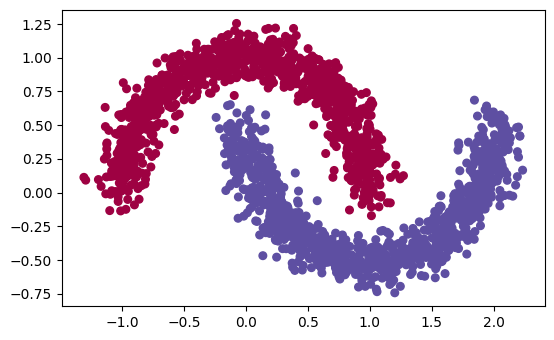

In [210]:
trainer = ModelTrainerExperiment1(n_train=2000, n_test=200, w_hidden=3)
ModelTrainerExperiment1.train(trainer)